In [1]:
# Importamos las librería necesarias para la manipulación y visualización de datos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import joblib

# Configurar el nivel de registro de TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # 0 = todos los mensajes, 1 = advertencias, 2 = errores, 3 = críticos

# Librerías para el procesamiento del modelo
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Librería para probar hiperparámetros
import keras_tuner as kt

# Librerías del modelo de red recurrente LSTM y GRU
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

2025-01-26 10:43:11.294564: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737884591.306370   32321 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737884591.310200   32321 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Leemos los csv con los datos de entrenamiento
ruta_train = "/mnt/c/Users/migue/Documents/Python/UNIR/TFE/datos_procesados_estaciones_train.csv"
df = pd.read_csv(ruta_train, sep=';', decimal='.')

# Leemos los csv con los datos de prueba
ruta_prueba = "/mnt/c/Users/migue/Documents/Python/UNIR/TFE/datos_procesados_estaciones_prueba.csv"
df_prueba = pd.read_csv(ruta_prueba, sep=';', decimal='.')

# Seleccionamos la estación 6667
df = df.loc[df['id'] == 6667]
df_prueba = df_prueba.loc[df_prueba['id'] == 6667]

In [3]:
# Mostramos los primeros datos
df.head()

,id,fecha,intensidad,ocupacion,carga,vmed,ANO,MES,DIA,HORA,MINUTO,DIA_SEMANA,TEMPERATURA,PRECIPITACION,FESTIVO,intensidad_media
455091,6667,2023-01-01 00:00:00,345.0,1.0,6.0,77.0,2023,1,1,0,0,6,7.6,0.0,0.0,189
455092,6667,2023-01-01 00:15:00,255.0,0.0,3.0,73.0,2023,1,1,0,15,6,7.6,0.0,0.0,163
455093,6667,2023-01-01 00:30:00,805.0,1.0,12.0,69.0,2023,1,1,0,30,6,7.6,0.0,0.0,632
455094,6667,2023-01-01 00:45:00,1496.0,2.0,22.0,66.0,2023,1,1,0,45,6,7.6,0.0,0.0,1229
455095,6667,2023-01-01 01:00:00,1688.0,3.0,27.0,64.0,2023,1,1,1,0,6,7.5,0.0,0.0,1701


In [4]:
# Mostramos los primeros datos
df_prueba.head()

,id,fecha,intensidad,ocupacion,carga,vmed,ANO,MES,DIA,HORA,MINUTO,DIA_SEMANA,TEMPERATURA,PRECIPITACION,FESTIVO,intensidad_media
112255,6667,2024-01-01 00:00:00,388.0,1.0,6.0,62.0,2024,1,1,0,0,0,6.5,0.0,1.0,194
112256,6667,2024-01-01 00:15:00,359.0,0.0,4.0,63.0,2024,1,1,0,15,0,6.5,0.0,1.0,175
112257,6667,2024-01-01 00:30:00,1020.0,1.0,17.0,60.0,2024,1,1,0,30,0,6.5,0.0,1.0,659
112258,6667,2024-01-01 00:45:00,1569.0,3.0,24.0,59.0,2024,1,1,0,45,0,6.5,0.0,1.0,1263
112259,6667,2024-01-01 01:00:00,1921.0,4.0,30.0,59.0,2024,1,1,1,0,0,6.3,0.0,1.0,1687


In [5]:
# Nos aseguramos que la columna 'fecha' esté en formato datetime
df['fecha'] = pd.to_datetime(df['fecha'])
df_prueba['fecha'] = pd.to_datetime(df_prueba['fecha'])

# Seleccionamos las columnas relevantes para el modelo
feature_cols = ['intensidad', 'intensidad_media', 'ocupacion', 'carga', 'vmed', 'HORA', 'DIA_SEMANA', 'TEMPERATURA', 'FESTIVO']
df_encoded = df[feature_cols]
df_encoded_prueba = df_prueba[feature_cols]


# Escalamos las características numéricas
scaler = StandardScaler()
df_encoded[feature_cols] = scaler.fit_transform(df_encoded[feature_cols])
df_encoded_prueba[feature_cols] = scaler.fit_transform(df_encoded_prueba[feature_cols])

# Creamos las secuencias para el modelo
window_size = 100  # 1 día (96 intervalos de 15 minutos)
n_features = len(feature_cols)

forecast_steps = 4  # Número de pasos a predecir
X = []
y = []

for i in range(window_size, len(df) - forecast_steps + 1):
    X.append(df_encoded.iloc[i-window_size:i].values)
    y.append(df_encoded.iloc[i:i+forecast_steps]['intensidad'].values)

X = np.array(X)
y = np.array(y)

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_prueba = []
y_prueba = []

# Operamos ahora con los datos de prueba
for i in range(window_size, len(df_prueba) - forecast_steps + 1):
    X_prueba.append(df_encoded_prueba.iloc[i-window_size:i].values)
    y_prueba.append(df_encoded_prueba.iloc[i:i+forecast_steps]['intensidad'].values)

X_prueba = np.array(X_prueba)
y_prueba = np.array(y_prueba)

/tmp/ipykernel_32321/2520768740.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_encoded[feature_cols] = scaler.fit_transform(df_encoded[feature_cols])
/tmp/ipykernel_32321/2520768740.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_encoded_prueba[feature_cols] = scaler.fit_transform(df_encoded_prueba[feature_cols])


In [6]:
# Verificar si TensorFlow detecta la GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPUs detectadas:", gpus)
    try:
        # Configurar TensorFlow para usar la GPU de manera eficiente
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("La GPU está configurada para su uso.")
    except RuntimeError as e:
        print("Error al configurar la GPU:", e)
else:
    print("No se detectaron GPUs. El entrenamiento se realizará en la CPU.")

GPUs detectadas: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
La GPU está configurada para su uso.


In [7]:
# Función para construir el modelo con una capa LSTM y una capa GRU
def build_tuned_lstm_gru(hp):

    # Indicamos que el modelo será secuencial, es decir, una secuencia de diferentes capas
    model = Sequential()

    # Primera capa LSTM
    model.add(LSTM(
        # El número de filtros variará entre 32 y 128 en pasos de 32
        units=hp.Int('lstm_units', min_value=32, max_value=128, step=32),
        # Función de activación tangencial
        activation='tanh',
        # La capa devolverá una secuencia completa de salidas. Esto es necesario al existir una segunda capa posterior
        return_sequences=True,
        # Forma de entrada definida por los datos de entrenamiento (X_train)
        input_shape=(X_train.shape[1], X_train.shape[2])
    ))
    # Capa Dropout que desactivará neuronas entre 0.2 y 0.5
    model.add(Dropout(hp.Float('dropout_lstm', min_value=0.2, max_value=0.5, step=0.1)))

    # Segunda capa GRU
    model.add(GRU(
        # El número de filtros variará entre 32 y 128 en pasos de 32
        units=hp.Int('gru_units', min_value=32, max_value=128, step=32),
        # Función de activación tangencial
        activation='tanh',
        # La capa devolverá el último paso temporal al ser la última
        return_sequences=False
    ))
    # Capa Dropout que desactivará neuronas entre 0.2 y 0.5
    model.add(Dropout(hp.Float('dropout_gru', min_value=0.2, max_value=0.5, step=0.1)))

    # Capa densa de salida
    model.add(Dense(forecast_steps, activation='linear'))  # Salida de varios pasos

    # Compilar el modelo
    model.compile(
        # Optimizador Adam
        optimizer='adam',
        # Función de pérdida MSE (error cuadrático medio)
        loss='mse',
        # Métrica MAE error absoluto medio
        metrics=['mae']
    )

    return model

# Definir el tuner para buscar hiperparámetros
tuner = kt.RandomSearch(
    # Función que construye el modelo
    build_tuned_lstm_gru,
    # Indicamos que queremos minimizar la pérdida de validación
    objective='val_loss',
    # Número de combinaciones a probar
    max_trials=10,
    # Número de ejecuciones por cada combinación de hiperparámetros
    executions_per_trial=1,
    # Ruta en la que se guardan los resultados para poder recuperarlos posteriormente
    directory='lstm_gru_hyperparameter_tuning',
    project_name='lstm_gru_tuning_estacion_6667'
)

# Detenemos el entrenamiento si no se observa mejora de la pérdidoa de validación tras 5 épocas consecutivas
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# Reducimos la tasa de aprendizaje a la mitad si no se observa mejora de la pérdidoa de validación tras 3 épocas consecutivas
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5)

# Realizamos la búsqueda de hiperparámetros
tuner.search(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, reduce_lr]
)

# Nos quedamos con los hiperparámetros que mejor resultado han ofrecido
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Mejores hiperparámetros:")
print(f" - Unidades LSTM: {best_hps.get('lstm_units')}")
print(f" - Dropout LSTM: {best_hps.get('dropout_lstm')}")
print(f" - Unidades GRU: {best_hps.get('gru_units')}")
print(f" - Dropout GRU: {best_hps.get('dropout_gru')}")

Trial 10 Complete [00h 10m 25s]
val_loss: 0.030987484380602837

Best val_loss So Far: 0.02830905094742775
Total elapsed time: 01h 45m 06s
Mejores hiperparámetros:
 - Unidades LSTM: 96
 - Dropout LSTM: 0.2
 - Unidades GRU: 96
 - Dropout GRU: 0.2


In [8]:
# Nos quedamos con el mejor modelo y los mejores hiperparámetros encontrados
best_model = tuner.hypermodel.build(best_hps)

# Resumen del modelo
best_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 100, 96)        │        40,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 100, 96)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 96)             │        55,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           388 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 96,964 (378.77 KB)

 Trainable params: 96,964 (378.77 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Entrenamos el modelo
history = best_model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/30
873/873 ━━━━━━━━━━━━━━━━━━━━ 28s 31ms/step - loss: 0.1247 - mae: 0.2533 - val_loss: 0.0639 - val_mae: 0.1779 - learning_rate: 0.0010
Epoch 2/30
873/873 ━━━━━━━━━━━━━━━━━━━━ 24s 27ms/step - loss: 0.0646 - mae: 0.1850 - val_loss: 0.0523 - val_mae: 0.1577 - learning_rate: 0.0010
Epoch 3/30
873/873 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - loss: 0.0561 - mae: 0.1719 - val_loss: 0.0455 - val_mae: 0.1461 - learning_rate: 0.0010
Epoch 4/30
873/873 ━━━━━━━━━━━━━━━━━━━━ 19s 22ms/step - loss: 0.0506 - mae: 0.1619 - val_loss: 0.0439 - val_mae: 0.1482 - learning_rate: 0.0010
Epoch 5/30
873/873 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - loss: 0.0466 - mae: 0.1558 - val_loss: 0.0423 - val_mae: 0.1447 - learning_rate: 0.0010
Epoch 6/30
873/873 ━━━━━━━━━━━━━━━━━━━━ 19s 22ms/step - loss: 0.0462 - mae: 0.1539 - val_loss: 0.0431 - val_mae: 0.1430 - learning_rate: 0.0010
Epoch 7/30
873/873 ━━━━━━━━━━━━━━━━━━━━ 19s 22ms/step - loss: 0.0435 - mae: 0.1510 - val_loss: 0.0395 - val_mae: 0.1358 - learning_rate:

In [10]:
# Calcular predicciones del conjunto de validación
y_pred = best_model.predict(X_test)  # Salida de forma (n_samples, forecast_steps)

# Reconstrucción y desescalado para cada paso
df_reconstructed = pd.DataFrame(np.zeros((len(y_test), len(feature_cols))), columns=feature_cols)

# Paso 1 (15 minutos)
df_reconstructed['intensidad'] = y_test[:, 0]
y_test_original_step1 = scaler.inverse_transform(df_reconstructed)[:, feature_cols.index('intensidad')]

df_reconstructed['intensidad'] = y_pred[:, 0]
y_pred_original_step1 = scaler.inverse_transform(df_reconstructed)[:, feature_cols.index('intensidad')]

# Paso 2 (30 minutos)
df_reconstructed['intensidad'] = y_test[:, 1]
y_test_original_step2 = scaler.inverse_transform(df_reconstructed)[:, feature_cols.index('intensidad')]

df_reconstructed['intensidad'] = y_pred[:, 1]
y_pred_original_step2 = scaler.inverse_transform(df_reconstructed)[:, feature_cols.index('intensidad')]

# Paso 3 (45 minutos)
df_reconstructed['intensidad'] = y_test[:, 2]
y_test_original_step3 = scaler.inverse_transform(df_reconstructed)[:, feature_cols.index('intensidad')]

df_reconstructed['intensidad'] = y_pred[:, 2]
y_pred_original_step3 = scaler.inverse_transform(df_reconstructed)[:, feature_cols.index('intensidad')]

# Paso 4 (60 minutos)
df_reconstructed['intensidad'] = y_test[:, 3]
y_test_original_step4 = scaler.inverse_transform(df_reconstructed)[:, feature_cols.index('intensidad')]

df_reconstructed['intensidad'] = y_pred[:, 3]
y_pred_original_step4 = scaler.inverse_transform(df_reconstructed)[:, feature_cols.index('intensidad')]

# Cálculo de métricas para el Paso 1
mae_step1 = mean_absolute_error(y_test[:, 0], y_pred[:, 0])
mse_step1 = mean_squared_error(y_test[:, 0], y_pred[:, 0])
rmse_step1 = np.sqrt(mse_step1)
r2_step1 = r2_score(y_test[:, 0], y_pred[:, 0])

# Cálculo de métricas para el Paso 2
mae_step2 = mean_absolute_error(y_test[:, 1], y_pred[:, 1])
mse_step2 = mean_squared_error(y_test[:, 1], y_pred[:, 1])
rmse_step2 = np.sqrt(mse_step2)
r2_step2 = r2_score(y_test[:, 1], y_pred[:, 1])

# Cálculo de métricas para el Paso 3
mae_step3 = mean_absolute_error(y_test[:, 2], y_pred[:, 2])
mse_step3 = mean_squared_error(y_test[:, 2], y_pred[:, 2])
rmse_step3 = np.sqrt(mse_step3)
r2_step3 = r2_score(y_test[:, 2], y_pred[:, 2])

# Cálculo de métricas para el Paso 4
mae_step4 = mean_absolute_error(y_test[:, 3], y_pred[:, 3])
mse_step4 = mean_squared_error(y_test[:, 3], y_pred[:, 3])
rmse_step4 = np.sqrt(mse_step4)
r2_step4 = r2_score(y_test[:, 3], y_pred[:, 3])

print(f"Paso 1 - MAE: {mae_step1}, MSE: {mse_step1}, RMSE: {rmse_step1}, R-squared: {r2_step1}")
print(f"Paso 2 - MAE: {mae_step2}, MSE: {mse_step2}, RMSE: {rmse_step2}, R-squared: {r2_step2}")
print(f"Paso 3 - MAE: {mae_step3}, MSE: {mse_step3}, RMSE: {rmse_step3}, R-squared: {r2_step3}")
print(f"Paso 4 - MAE: {mae_step4}, MSE: {mse_step4}, RMSE: {rmse_step4}, R-squared: {r2_step4}")

219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
Paso 1 - MAE: 0.10737548852436703, MSE: 0.024329879353530832, RMSE: 0.15598038130973663, R-squared: 0.9760429942203902
Paso 2 - MAE: 0.1126050673207651, MSE: 0.02807975976964687, RMSE: 0.16757016372148972, R-squared: 0.9722293735236818
Paso 3 - MAE: 0.11653846125774005, MSE: 0.029946338554954034, RMSE: 0.17305010417492975, R-squared: 0.9704521415937224
Paso 4 - MAE: 0.11896616118074518, MSE: 0.031662147634505804, RMSE: 0.17793860636327857, R-squared: 0.9686911558619531


#### Gráficas

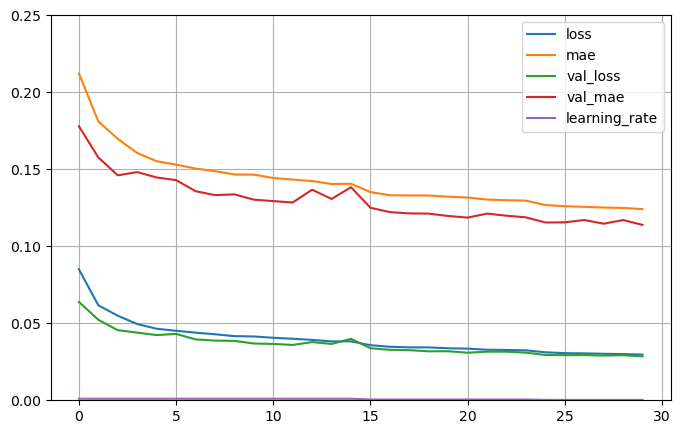

In [11]:
# Mostramos la evolución de las métricas a lo largo del entrenamiento
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,0.25)
plt.show()

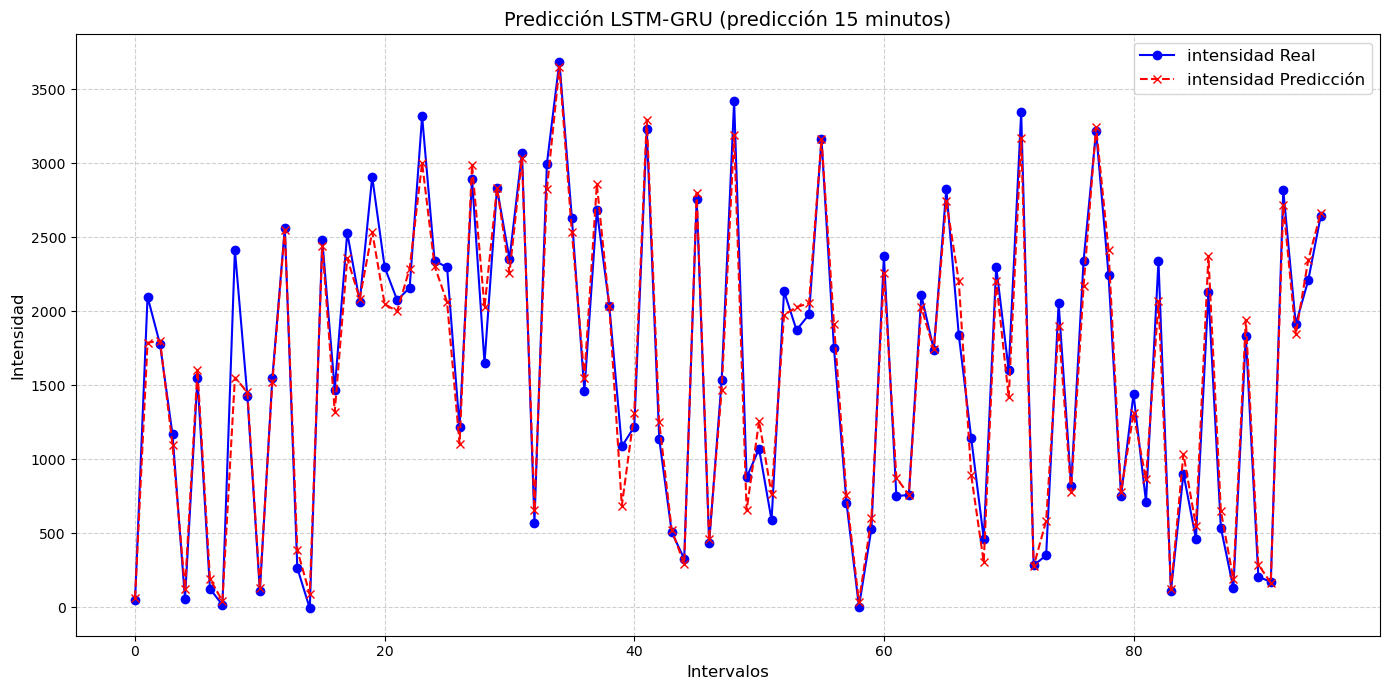

In [12]:
# Graficar resultados en la escala original
plt.figure(figsize=(14, 7))

# Mostrar solo los últimos 96 intervalos
plt.plot(y_test_original_step1[-96:], label='intensidad Real', color='blue', marker='o', linestyle='-')
plt.plot(y_pred_original_step1[-96:], label='intensidad Predicción', color='red', marker='x', linestyle='--')

plt.title('Predicción LSTM-GRU (predicción 15 minutos)', fontsize=14)
plt.xlabel('Intervalos', fontsize=12)
plt.ylabel('Intensidad', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


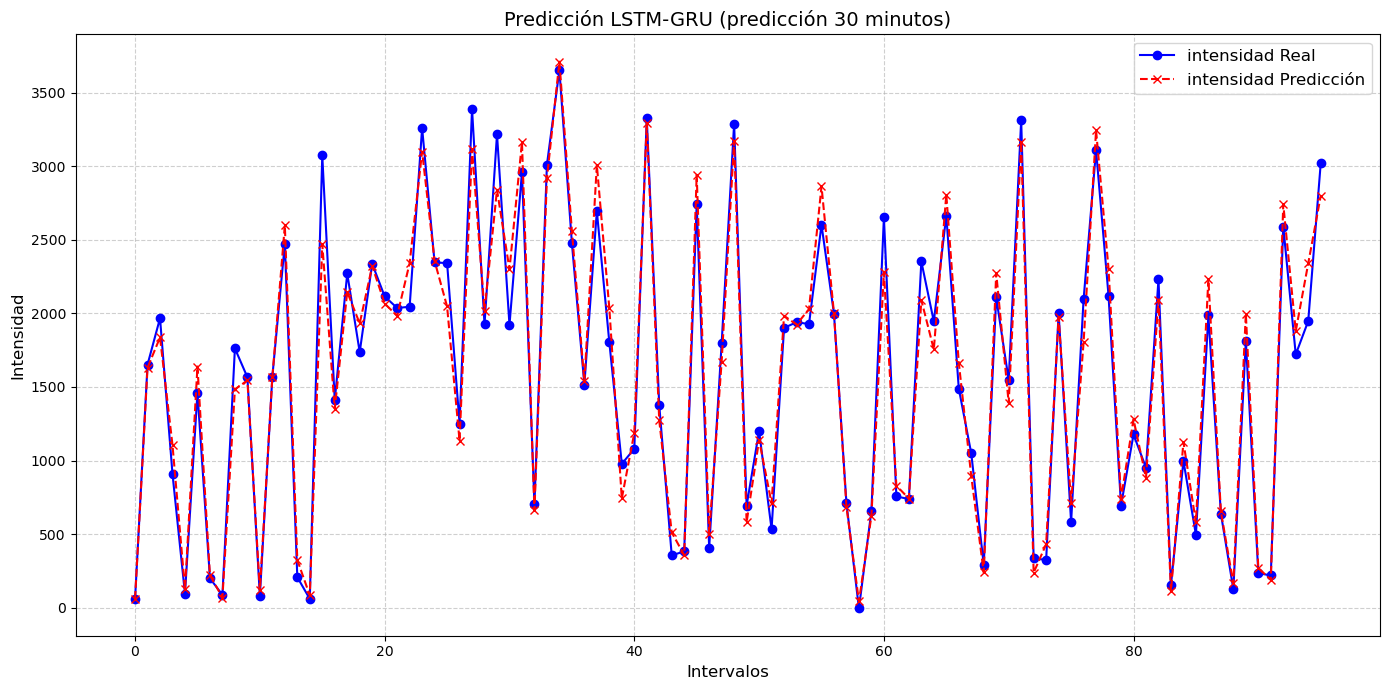

In [13]:
# Graficar resultados en la escala original
plt.figure(figsize=(14, 7))

# Mostrar solo los últimos 96 intervalos
plt.plot(y_test_original_step2[-96:], label='intensidad Real', color='blue', marker='o', linestyle='-')
plt.plot(y_pred_original_step2[-96:], label='intensidad Predicción', color='red', marker='x', linestyle='--')

plt.title('Predicción LSTM-GRU (predicción 30 minutos)', fontsize=14)
plt.xlabel('Intervalos', fontsize=12)
plt.ylabel('Intensidad', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

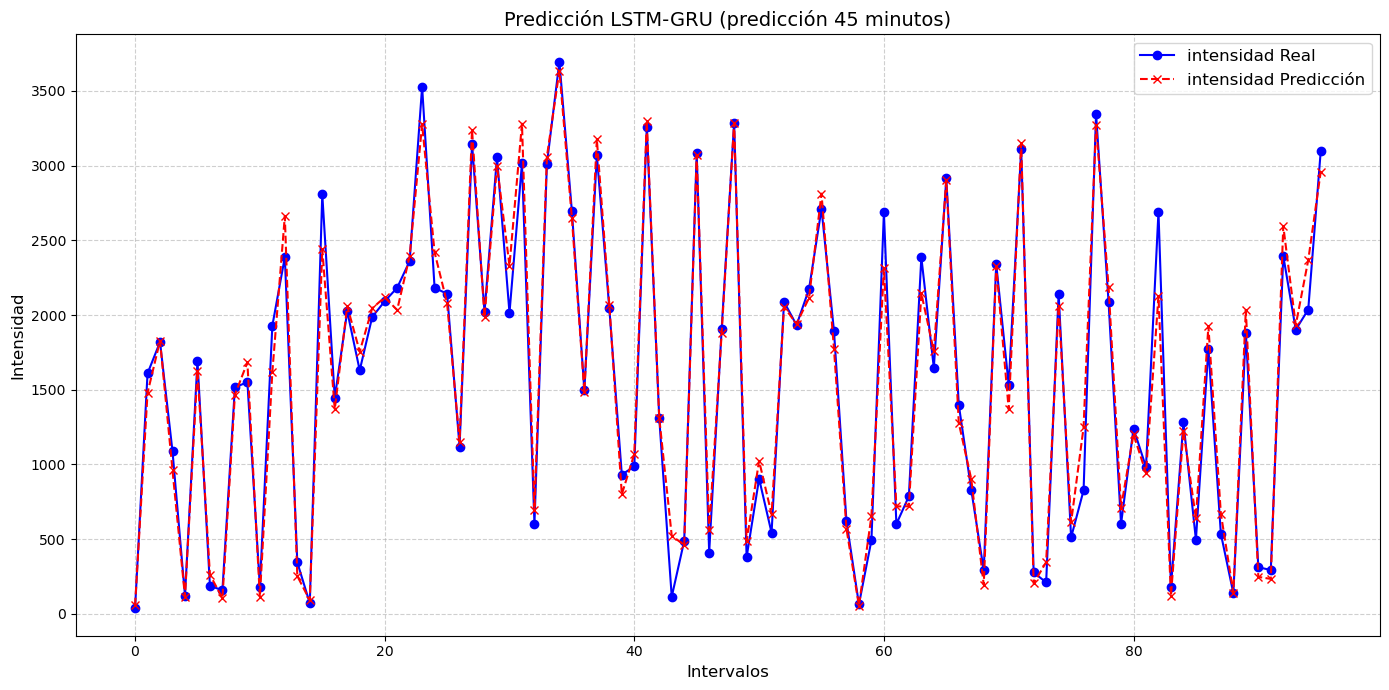

In [14]:
# Graficar resultados en la escala original
plt.figure(figsize=(14, 7))

# Mostrar solo los últimos 96 intervalos
plt.plot(y_test_original_step3[-96:], label='intensidad Real', color='blue', marker='o', linestyle='-')
plt.plot(y_pred_original_step3[-96:], label='intensidad Predicción', color='red', marker='x', linestyle='--')

plt.title('Predicción LSTM-GRU (predicción 45 minutos)', fontsize=14)
plt.xlabel('Intervalos', fontsize=12)
plt.ylabel('Intensidad', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

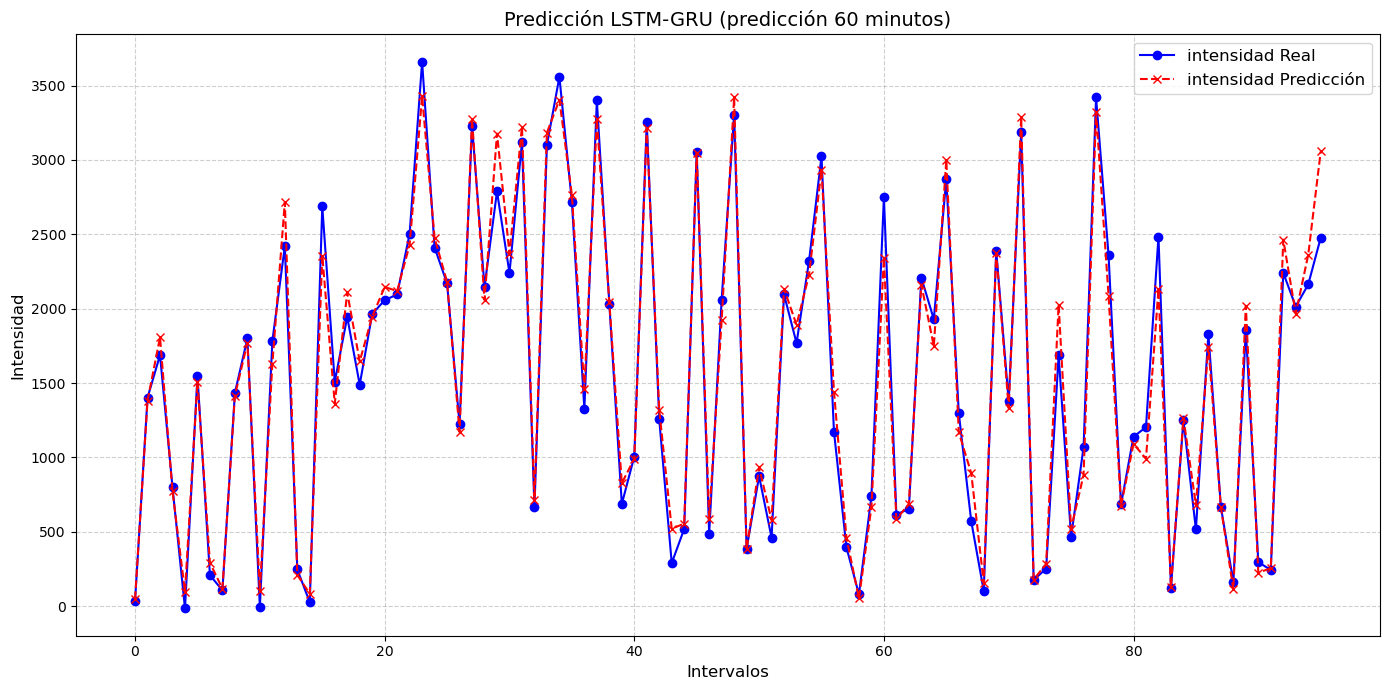

In [15]:
# Graficar resultados en la escala original
plt.figure(figsize=(14, 7))

# Mostrar solo los últimos 96 intervalos
plt.plot(y_test_original_step4[-96:], label='intensidad Real', color='blue', marker='o', linestyle='-')
plt.plot(y_pred_original_step4[-96:], label='intensidad Predicción', color='red', marker='x', linestyle='--')

plt.title('Predicción LSTM-GRU (predicción 60 minutos)', fontsize=14)
plt.xlabel('Intervalos', fontsize=12)
plt.ylabel('Intensidad', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

### Guardamos el modelo

In [16]:
# Ruta para guardar el modelo
ruta_modelo = '/mnt/c/Users/migue/Documents/Python/UNIR/TFE/Estacion 6667/best_model_LSTM-GRU.pkl'

# Guardamos el modelo
joblib.dump(best_model, ruta_modelo)

print(f"Modelo guardado en {ruta_modelo}")

Modelo guardado en /mnt/c/Users/migue/Documents/Python/UNIR/TFE/Estacion 6667/best_model_LSTM-GRU.pkl


## Validación con un conjunto de datos no visto por el modelo

In [17]:
# Calcular predicciones del conjunto de validación
y_pred = best_model.predict(X_prueba)  # Salida de forma (n_samples, forecast_steps)

# Reconstrucción y desescalado para cada paso
df_reconstructed = pd.DataFrame(np.zeros((len(y_prueba), len(feature_cols))), columns=feature_cols)

# Paso 1 (primer intervalo)
df_reconstructed['intensidad'] = y_prueba[:, 0]
y_prueba_original_step1 = scaler.inverse_transform(df_reconstructed)[:, feature_cols.index('intensidad')]

df_reconstructed['intensidad'] = y_pred[:, 0]
y_pred_original_step1 = scaler.inverse_transform(df_reconstructed)[:, feature_cols.index('intensidad')]

# Paso 2 (30 minutos)
df_reconstructed['intensidad'] = y_prueba[:, 1]
y_prueba_original_step2 = scaler.inverse_transform(df_reconstructed)[:, feature_cols.index('intensidad')]

df_reconstructed['intensidad'] = y_pred[:, 1]
y_pred_original_step2 = scaler.inverse_transform(df_reconstructed)[:, feature_cols.index('intensidad')]

# Paso 3 (45 minutos)
df_reconstructed['intensidad'] = y_prueba[:, 2]
y_prueba_original_step3 = scaler.inverse_transform(df_reconstructed)[:, feature_cols.index('intensidad')]

df_reconstructed['intensidad'] = y_pred[:, 2]
y_pred_original_step3 = scaler.inverse_transform(df_reconstructed)[:, feature_cols.index('intensidad')]

# Paso 4 (60 minutos)
df_reconstructed['intensidad'] = y_prueba[:, 3]
y_prueba_original_step4 = scaler.inverse_transform(df_reconstructed)[:, feature_cols.index('intensidad')]

df_reconstructed['intensidad'] = y_pred[:, 3]
y_pred_original_step4 = scaler.inverse_transform(df_reconstructed)[:, feature_cols.index('intensidad')]

# Cálculo de métricas para el Paso 1
mae_step1 = mean_absolute_error(y_prueba[:, 0], y_pred[:, 0])
mse_step1 = mean_squared_error(y_prueba[:, 0], y_pred[:, 0])
rmse_step1 = np.sqrt(mse_step1)
r2_step1 = r2_score(y_prueba[:, 0], y_pred[:, 0])

# Cálculo de métricas para el Paso 2
mae_step2 = mean_absolute_error(y_prueba[:, 1], y_pred[:, 1])
mse_step2 = mean_squared_error(y_prueba[:, 1], y_pred[:, 1])
rmse_step2 = np.sqrt(mse_step2)
r2_step2 = r2_score(y_prueba[:, 1], y_pred[:, 1])

# Cálculo de métricas para el Paso 3
mae_step3 = mean_absolute_error(y_prueba[:, 2], y_pred[:, 2])
mse_step3 = mean_squared_error(y_prueba[:, 2], y_pred[:, 2])
rmse_step3 = np.sqrt(mse_step3)
r2_step3 = r2_score(y_prueba[:, 2], y_pred[:, 2])

# Cálculo de métricas para el Paso 4
mae_step4 = mean_absolute_error(y_prueba[:, 3], y_pred[:, 3])
mse_step4 = mean_squared_error(y_prueba[:, 3], y_pred[:, 3])
rmse_step4 = np.sqrt(mse_step4)
r2_step4 = r2_score(y_prueba[:, 3], y_pred[:, 3])

print(f"Paso 1 - MAE: {mae_step1}, MSE: {mse_step1}, RMSE: {rmse_step1}, R-squared: {r2_step1}")
print(f"Paso 2 - MAE: {mae_step2}, MSE: {mse_step2}, RMSE: {rmse_step2}, R-squared: {r2_step2}")
print(f"Paso 3 - MAE: {mae_step3}, MSE: {mse_step3}, RMSE: {rmse_step3}, R-squared: {r2_step3}")
print(f"Paso 4 - MAE: {mae_step4}, MSE: {mse_step4}, RMSE: {rmse_step4}, R-squared: {r2_step4}")

267/267 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
Paso 1 - MAE: 0.16408791656340774, MSE: 0.04946818223792433, RMSE: 0.22241443801589036, R-squared: 0.9509024127659447
Paso 2 - MAE: 0.18969262701984782, MSE: 0.06749826774403729, RMSE: 0.2598042873857883, R-squared: 0.9329983742198245
Paso 3 - MAE: 0.20772636041113268, MSE: 0.0825819638079246, RMSE: 0.28737077758172386, R-squared: 0.9180150173500047
Paso 4 - MAE: 0.21675243382644846, MSE: 0.08867389978841393, RMSE: 0.2977816310459964, R-squared: 0.9119538920112111


#### Gráficas

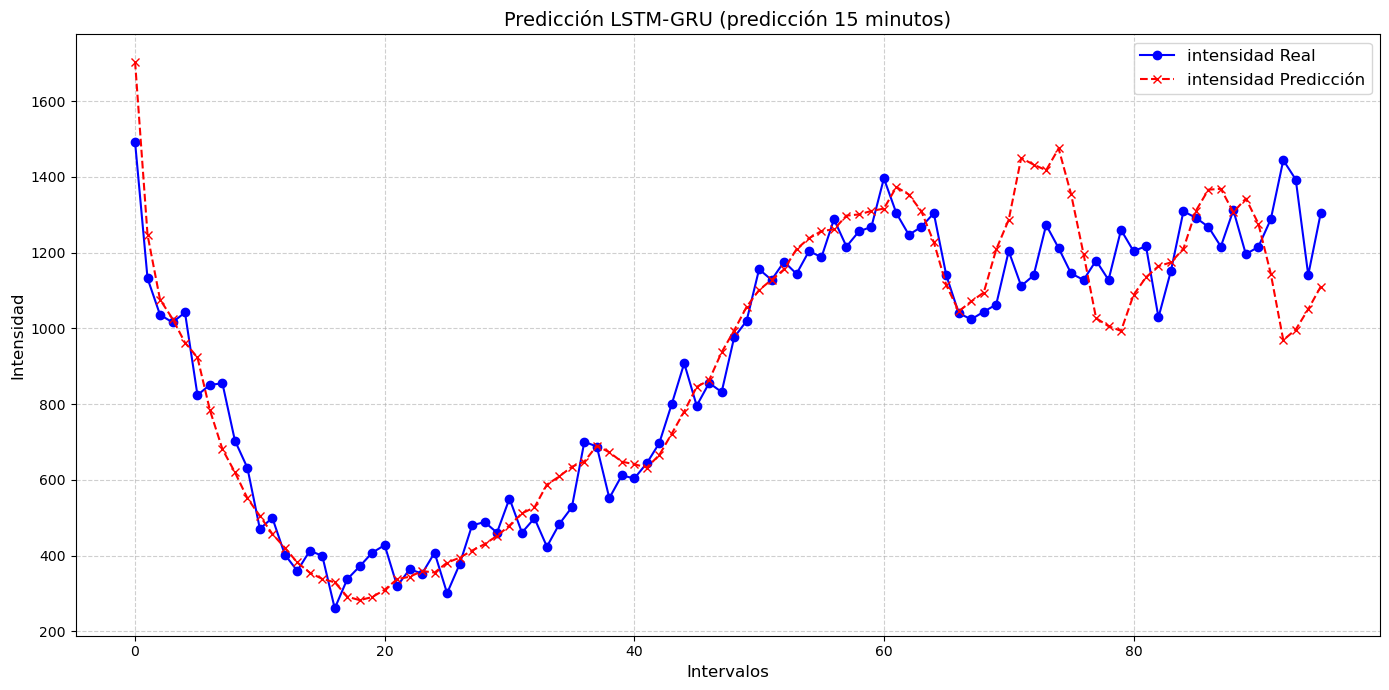

In [18]:
# Graficar resultados en la escala original
plt.figure(figsize=(14, 7))

# Mostrar solo los últimos 96 intervalos
plt.plot(y_prueba_original_step1[-96:], label='intensidad Real', color='blue', marker='o', linestyle='-')
plt.plot(y_pred_original_step1[-96:], label='intensidad Predicción', color='red', marker='x', linestyle='--')

plt.title('Predicción LSTM-GRU (predicción 15 minutos)', fontsize=14)
plt.xlabel('Intervalos', fontsize=12)
plt.ylabel('Intensidad', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

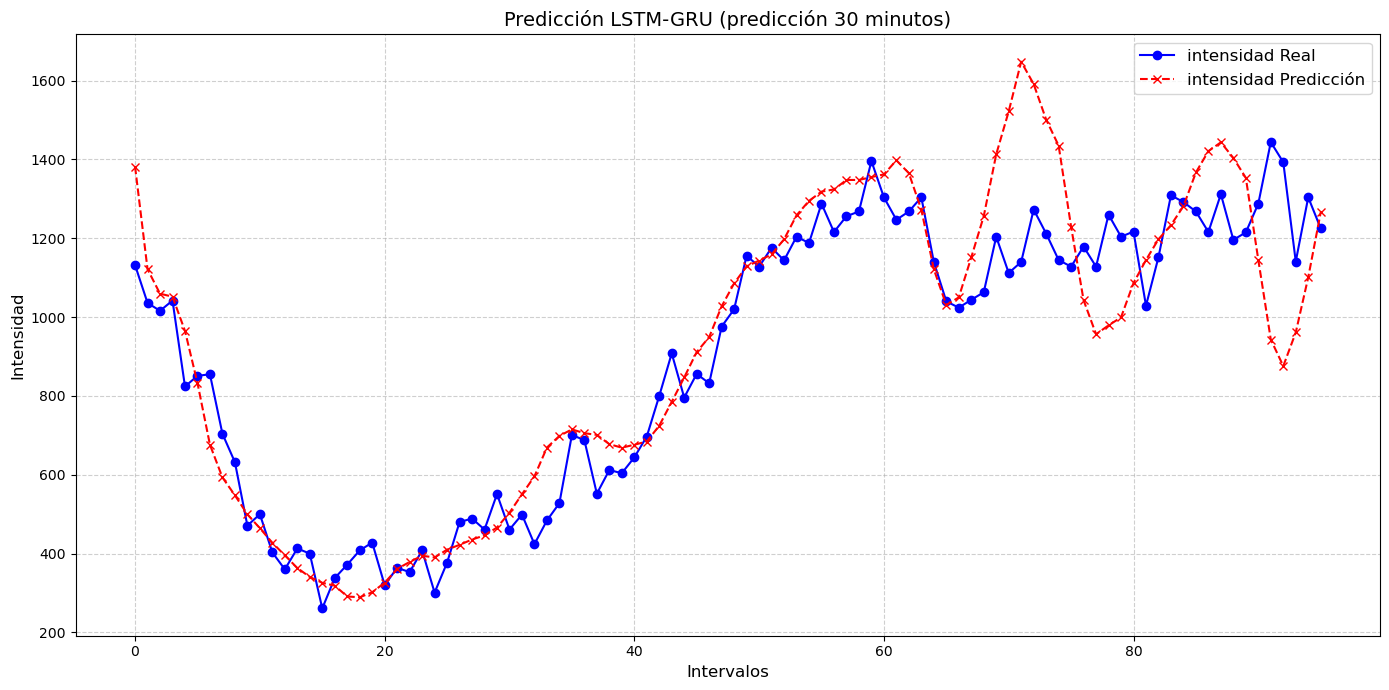

In [19]:
# Graficar resultados en la escala original
plt.figure(figsize=(14, 7))

# Mostrar solo los últimos 96 intervalos
plt.plot(y_prueba_original_step2[-96:], label='intensidad Real', color='blue', marker='o', linestyle='-')
plt.plot(y_pred_original_step2[-96:], label='intensidad Predicción', color='red', marker='x', linestyle='--')

plt.title('Predicción LSTM-GRU (predicción 30 minutos)', fontsize=14)
plt.xlabel('Intervalos', fontsize=12)
plt.ylabel('Intensidad', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

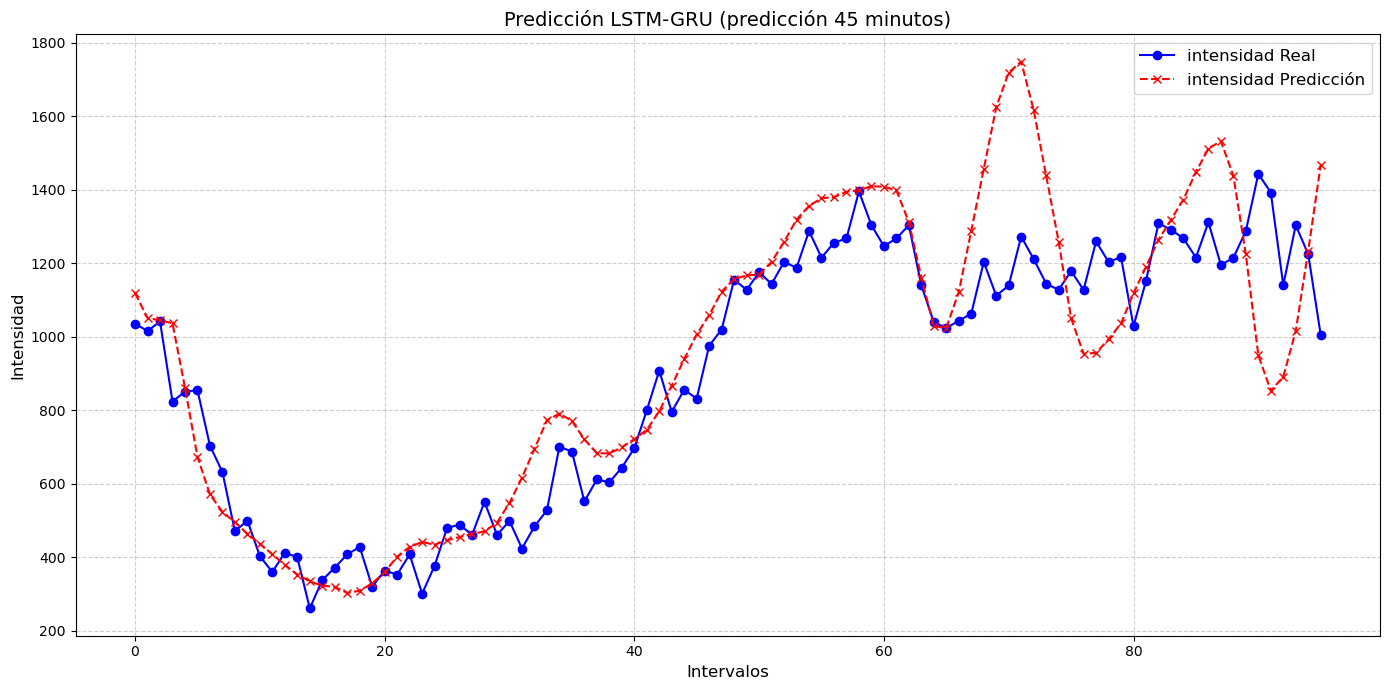

In [20]:
# Graficar resultados en la escala original
plt.figure(figsize=(14, 7))

# Mostrar solo los últimos 96 intervalos
plt.plot(y_prueba_original_step3[-96:], label='intensidad Real', color='blue', marker='o', linestyle='-')
plt.plot(y_pred_original_step3[-96:], label='intensidad Predicción', color='red', marker='x', linestyle='--')

plt.title('Predicción LSTM-GRU (predicción 45 minutos)', fontsize=14)
plt.xlabel('Intervalos', fontsize=12)
plt.ylabel('Intensidad', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

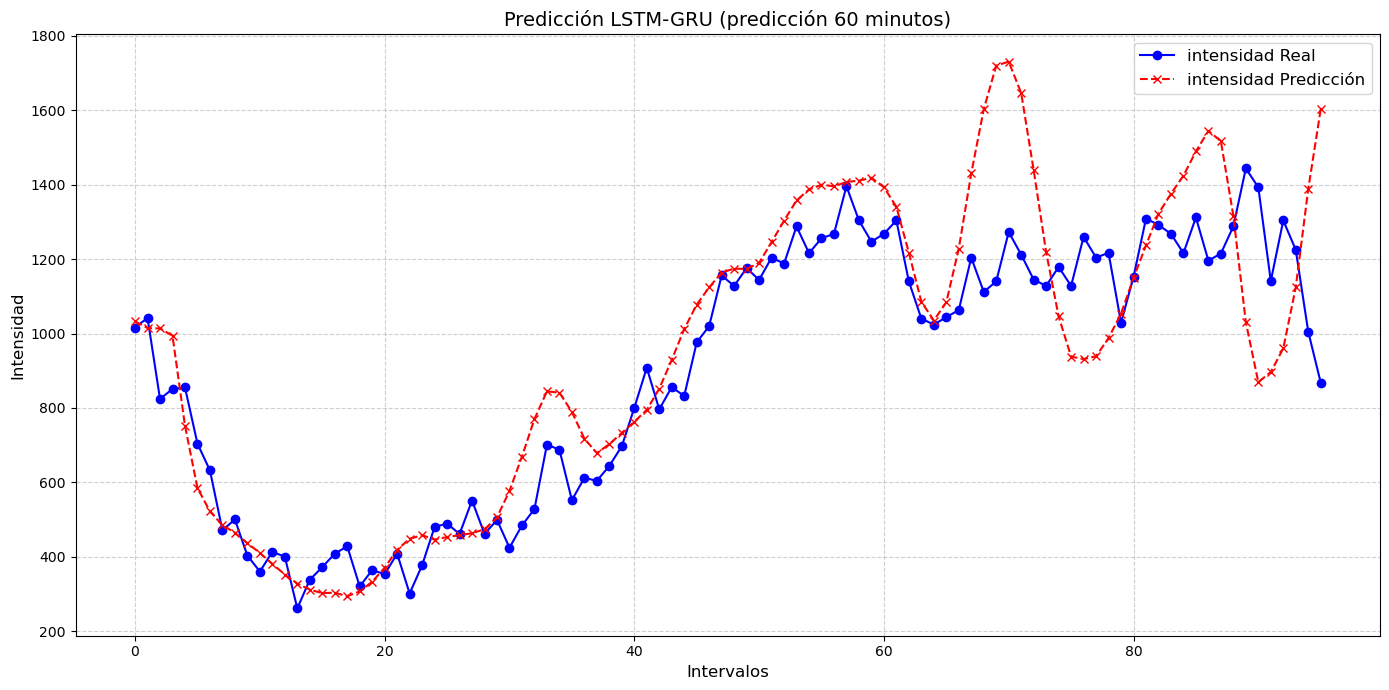

In [21]:
# Graficar resultados en la escala original
plt.figure(figsize=(14, 7))

# Mostrar solo los últimos 96 intervalos
plt.plot(y_prueba_original_step4[-96:], label='intensidad Real', color='blue', marker='o', linestyle='-')
plt.plot(y_pred_original_step4[-96:], label='intensidad Predicción', color='red', marker='x', linestyle='--')

plt.title('Predicción LSTM-GRU (predicción 60 minutos)', fontsize=14)
plt.xlabel('Intervalos', fontsize=12)
plt.ylabel('Intensidad', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

#### Prueba una única estación  
Probamos el modelo sobre la estación 3490 (Km 10.8 de la M-30).

In [22]:
# Leemos los csv con los datos de entrenamiento
ruta_estacion_prueba = "/mnt/c/Users/migue/Documents/Python/UNIR/TFE/datos_procesados_estaciones_prueba.csv"
df_estacion = pd.read_csv(ruta_estacion_prueba, sep=';', decimal='.')

# Creamos el conjunto con los datos de la estación 3490
datos_3490 = df_estacion[df_estacion['id'] == 3490]

In [23]:
# Preparamos los datos de la estación
# Nos aseguramos que la columna 'fecha' esté en formato datetime
datos_3490['fecha'] = pd.to_datetime(datos_3490['fecha'])

# Seleccionamos las columnas relevantes para el modelo
df_encoded_3490 = datos_3490[feature_cols]


# Escalamos las características numéricas
scaler = StandardScaler()
df_encoded_3490[feature_cols] = scaler.fit_transform(df_encoded_3490[feature_cols])


X_3490 = []
y_3490 = []

# Operamos ahora con los datos de prueba
for i in range(window_size, len(datos_3490) - forecast_steps + 1):
    X_3490.append(df_encoded_3490.iloc[i-window_size:i].values)
    y_3490.append(df_encoded_3490.iloc[i:i+forecast_steps]['intensidad'].values)

X_3490 = np.array(X_3490)
y_3490 = np.array(y_3490)

/tmp/ipykernel_32321/942581670.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datos_3490['fecha'] = pd.to_datetime(datos_3490['fecha'])
/tmp/ipykernel_32321/942581670.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_encoded_3490[feature_cols] = scaler.fit_transform(df_encoded_3490[feature_cols])


In [24]:
# Calcular predicciones del conjunto de validación
y_pred = best_model.predict(X_3490)  # Salida de forma (n_samples, forecast_steps)

# Reconstrucción y desescalado para cada paso
df_reconstructed = pd.DataFrame(np.zeros((len(y_3490), len(feature_cols))), columns=feature_cols)

# Paso 1 (primer intervalo)
df_reconstructed['intensidad'] = y_3490[:, 0]
y_3490_original_step1 = scaler.inverse_transform(df_reconstructed)[:, feature_cols.index('intensidad')]

df_reconstructed['intensidad'] = y_pred[:, 0]
y_pred_original_step1 = scaler.inverse_transform(df_reconstructed)[:, feature_cols.index('intensidad')]

# Paso 2 (30 minutos)
df_reconstructed['intensidad'] = y_3490[:, 1]
y_3490_original_step2 = scaler.inverse_transform(df_reconstructed)[:, feature_cols.index('intensidad')]

df_reconstructed['intensidad'] = y_pred[:, 1]
y_pred_original_step2 = scaler.inverse_transform(df_reconstructed)[:, feature_cols.index('intensidad')]

# Paso 3 (45 minutos)
df_reconstructed['intensidad'] = y_3490[:, 2]
y_3490_original_step3 = scaler.inverse_transform(df_reconstructed)[:, feature_cols.index('intensidad')]

df_reconstructed['intensidad'] = y_pred[:, 2]
y_pred_original_step3 = scaler.inverse_transform(df_reconstructed)[:, feature_cols.index('intensidad')]

# Paso 4 (60 minutos)
df_reconstructed['intensidad'] = y_3490[:, 3]
y_3490_original_step4 = scaler.inverse_transform(df_reconstructed)[:, feature_cols.index('intensidad')]

df_reconstructed['intensidad'] = y_pred[:, 3]
y_pred_original_step4 = scaler.inverse_transform(df_reconstructed)[:, feature_cols.index('intensidad')]

# Cálculo de métricas para el Paso 1
mae_step1 = mean_absolute_error(y_3490[:, 0], y_pred[:, 0])
mse_step1 = mean_squared_error(y_3490[:, 0], y_pred[:, 0])
rmse_step1 = np.sqrt(mse_step1)
r2_step1 = r2_score(y_3490[:, 0], y_pred[:, 0])

# Cálculo de métricas para el Paso 2
mae_step2 = mean_absolute_error(y_3490[:, 1], y_pred[:, 1])
mse_step2 = mean_squared_error(y_3490[:, 1], y_pred[:, 1])
rmse_step2 = np.sqrt(mse_step2)
r2_step2 = r2_score(y_3490[:, 1], y_pred[:, 1])

# Cálculo de métricas para el Paso 3
mae_step3 = mean_absolute_error(y_3490[:, 2], y_pred[:, 2])
mse_step3 = mean_squared_error(y_3490[:, 2], y_pred[:, 2])
rmse_step3 = np.sqrt(mse_step3)
r2_step3 = r2_score(y_3490[:, 2], y_pred[:, 2])

# Cálculo de métricas para el Paso 4
mae_step4 = mean_absolute_error(y_3490[:, 3], y_pred[:, 3])
mse_step4 = mean_squared_error(y_3490[:, 3], y_pred[:, 3])
rmse_step4 = np.sqrt(mse_step4)
r2_step4 = r2_score(y_3490[:, 3], y_pred[:, 3])

print(f"Paso 1 - MAE: {mae_step1}, MSE: {mse_step1}, RMSE: {rmse_step1}, R-squared: {r2_step1}")
print(f"Paso 2 - MAE: {mae_step2}, MSE: {mse_step2}, RMSE: {rmse_step2}, R-squared: {r2_step2}")
print(f"Paso 3 - MAE: {mae_step3}, MSE: {mse_step3}, RMSE: {rmse_step3}, R-squared: {r2_step3}")
print(f"Paso 4 - MAE: {mae_step4}, MSE: {mse_step4}, RMSE: {rmse_step4}, R-squared: {r2_step4}")

267/267 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
Paso 1 - MAE: 0.21121294245266192, MSE: 0.10241511315470432, RMSE: 0.3200236134329845, R-squared: 0.8979238453996448
Paso 2 - MAE: 0.24631258629544747, MSE: 0.13396044280628625, RMSE: 0.36600606935717095, R-squared: 0.8664537492200677
Paso 3 - MAE: 0.2664114261429242, MSE: 0.15302181796111852, RMSE: 0.39118003267181023, R-squared: 0.8474137698057135
Paso 4 - MAE: 0.27837399906985566, MSE: 0.16528603089006874, RMSE: 0.4065538474668131, R-squared: 0.8351447152043135


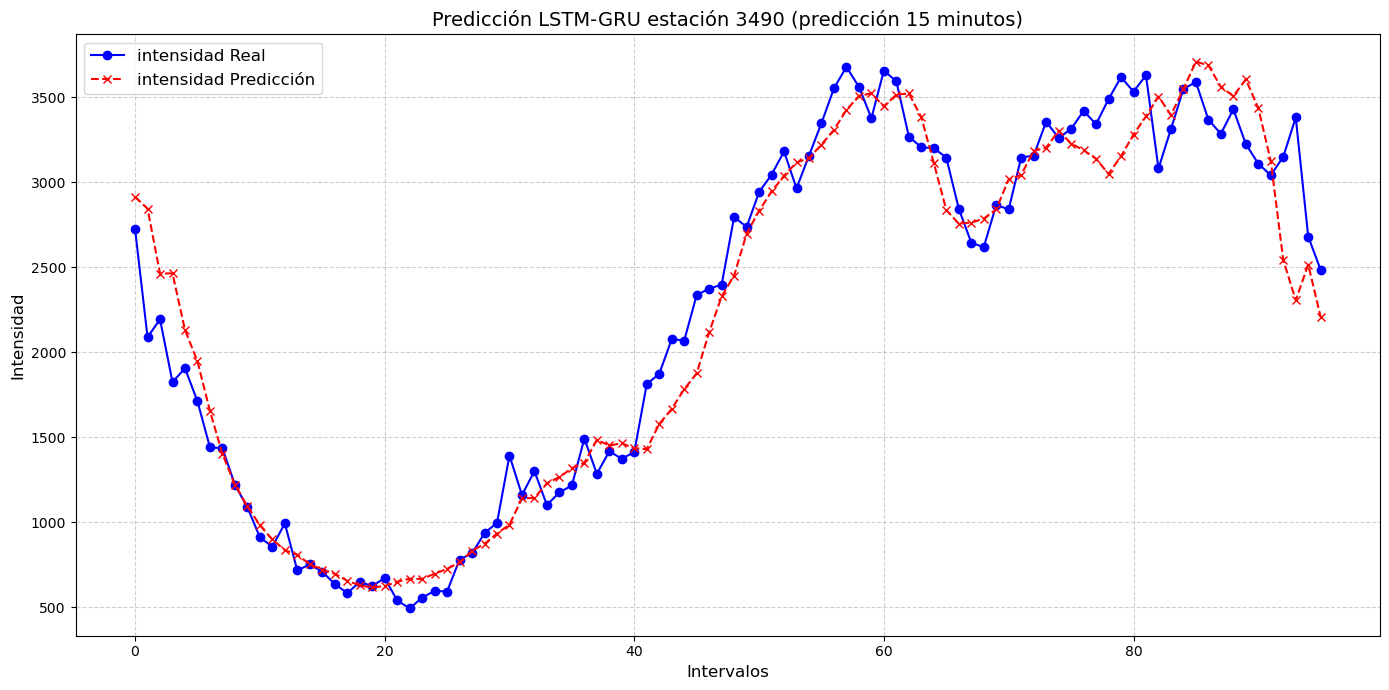

In [25]:
# Graficar resultados en la escala original
plt.figure(figsize=(14, 7))

# Mostrar solo los últimos 96 intervalos
plt.plot(y_3490_original_step1[-96:], label='intensidad Real', color='blue', marker='o', linestyle='-')
plt.plot(y_pred_original_step1[-96:], label='intensidad Predicción', color='red', marker='x', linestyle='--')

plt.title('Predicción LSTM-GRU estación 3490 (predicción 15 minutos)', fontsize=14)
plt.xlabel('Intervalos', fontsize=12)
plt.ylabel('Intensidad', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

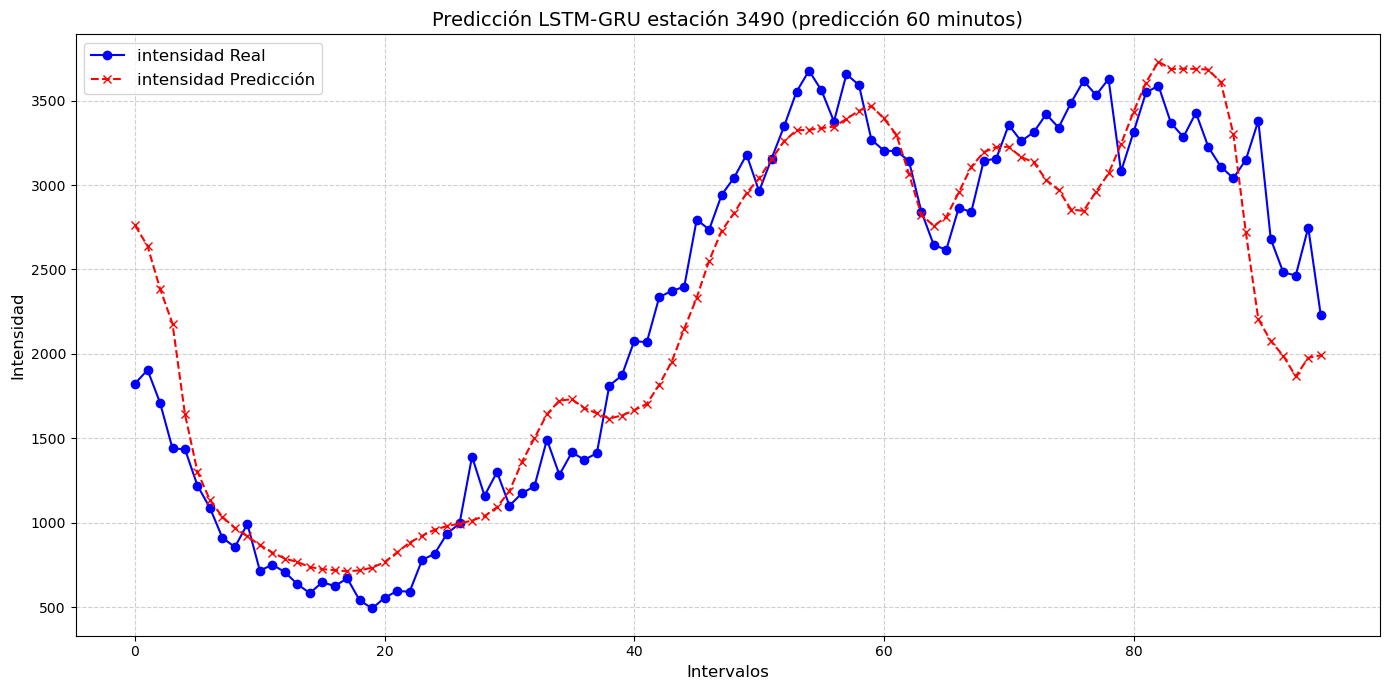

In [26]:
# Graficar resultados en la escala original
plt.figure(figsize=(14, 7))

# Mostrar solo los últimos 96 intervalos
plt.plot(y_3490_original_step4[-96:], label='intensidad Real', color='blue', marker='o', linestyle='-')
plt.plot(y_pred_original_step4[-96:], label='intensidad Predicción', color='red', marker='x', linestyle='--')

plt.title('Predicción LSTM-GRU estación 3490 (predicción 60 minutos)', fontsize=14)
plt.xlabel('Intervalos', fontsize=12)
plt.ylabel('Intensidad', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()